In [7]:
path=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/'
#import sys
#sys.path.append(path) 
path_=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model/'
import sys
sys.path.append(path_) 

In [1]:
path=  'C:/Users/felip/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/'
#import sys
#sys.path.append(path) 
path_=  'C:/Users/felip/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model/'
import sys
sys.path.append(path_) 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from joblib import dump, load
from nilearn import plotting
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.stats import linregress


class BaseClassifier:
    def __init__(self,save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None,fit_params_train=None, models_params_train=None, name_model=None):             
       
        self.scaler = scaler if scaler is not None else StandardScaler()
        self.params = params if params is not None else {}
        self.params_space = params_space if params_space is not None else {}
        self.fit_params_search = fit_params_search if fit_params_search is not None else {}
        self.model_params_search = model_params_search if model_params_search is not None else {}
        self.fit_params_train = fit_params_train if fit_params_train is not None else {}
        self.model_params_train = models_params_train if models_params_train is not None else {}

        self.save_path = save_path
        self.model_ml = None
        self.name_model = name_model
        self.model = None
        self.opt_model = None
        self.explainer = None

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

        self.x_train_kf = None
        self.y_train_kf= None

        self.early_stopping_rounds = 10

        self.residual_model = None


    def search_best_model(self,  X=None, y=None, param_space_=None, n_iter_=10, n_jobs_=-1, scoring_metric='accuracy', type_model=1):
       
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        if param_space_ is None:
            param_space = self.params_space
        else:
            param_space = param_space_

        n_splits = 10
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)       
        
        if type_model == 1:
            model = self.model_ml(**self.model_params_search)
        if type_model == 2:
            model = self.model_ml 

        opt_model = BayesSearchCV(
            estimator=model,
            search_spaces=param_space,
            #fit_params=self.fit_param,
            cv=kf,
            n_iter=n_iter_,
            #scoring=scoring_metric,
            n_jobs=n_jobs_,
            random_state=42,
            verbose=1
        )                
        opt_model.fit(X, y, **self.fit_params_search)
        best_params_return = dict(opt_model.best_params_)  

        return opt_model, best_params_return
    

    def trainer(self, df, n_splits=10, n_iterations=20, params_=None, type_model=1, scaler=2, early_stop=False):
        
        if params_ is None:
            params = self.params
        else:
            params = params_


        
        
        # Preparar el dataframe de controles
        X = df.iloc[:, :-2]  # Features
        y = df.iloc[:, -2]   # Labels (Age)
        ID = df.iloc[:, -1]  # IDs
        results_per_fold_train = []
        results_per_fold_test = []
                
        results_labels_df_train = pd.DataFrame(columns=['y_labels','y_pred','y_prob', 'ID-unique-2'])
        results_labels_df_test = pd.DataFrame(columns=['y_labels', 'y_pred','y_prob', 'ID-unique-2'])

        # Inicializar resultados
        results = {'model': [],
                    'mean_X_train_kf':[],
                    'std_X_train_kf':[],
                    'min_X_train_kf':[],
                    'max_X_train_kf':[],
                    'slope': [],
                    'intercept': [],
                    }
        
        # Bucle de iteraciones
        for i in range(n_iterations):
            # Crear validación cruzada para CN
            kf_CN = KFold(n_splits=n_splits, shuffle=True, random_state=i)
            kf_splits = list(kf_CN.split(X, y))
            
            for fold in range(n_splits):
                # Obtener índices de entrenamiento y prueba para CN
                train_index, test_index = kf_splits[fold]
                X_train_kf, X_test_kf_CN = X.iloc[train_index], X.iloc[test_index]
                y_train_kf, y_test_kf_CN = y.iloc[train_index], y.iloc[test_index]
                id_train_kf = ID.iloc[train_index]
                id_test_kf = ID.iloc[test_index]

                mean_X_train_kf = X_train_kf.mean()
                std_X_train_kf = X_train_kf.std()
                min_X_train_kf = X_train_kf.min()
                max_X_train_kf = X_train_kf.max()

                # Escalar los datos de acuerdo con el parámetro scaler
                if scaler == 1:
                    # No escalar
                    X_train_kf_scaled = X_train_kf
                    X_test_kf_scaled = X_test_kf_CN
                elif scaler == 2:
                    # Z-score scaling                    
                    X_train_kf_scaled = (X_train_kf - mean_X_train_kf) / std_X_train_kf
                    X_test_kf_scaled = (X_test_kf_CN - mean_X_train_kf) / std_X_train_kf
                elif scaler == 3:
                    # MinMax scaling (manual)                    
                    X_train_kf_scaled = (X_train_kf - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)
                    X_test_kf_scaled = (X_test_kf_CN - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)

                self.x_train_kf = X_train_kf_scaled
                self.y_train_kf=y_train_kf


                # Entrenar el modelo con CN
                if type_model == 1:
                    model = self.model_ml(**params, **self.model_params_train)
                if type_model == 2:
                    model = self.model_ml

                if early_stop:
                    self.fit_params_train = {
                    "early_stopping_rounds": self.early_stopping_rounds,
                    "eval_set": "mae",
                    "eval_set": self.get_eval_set(),
                    "verbose": False
                    }

                    
                model.fit(X_train_kf_scaled, y_train_kf,**self.fit_params_train)

                y_pred_CN_train = model.predict(X_train_kf_scaled)
                y_prob_CN_train = model.predict_proba(X_train_kf_scaled)[:, 1]

                # Hacer predicciones para el conjunto de prueba de CN
                y_pred_CN_test = model.predict(X_test_kf_scaled)
                y_prob_CN_test = model.predict_proba(X_test_kf_scaled)[:, 1]
                
                # Guardar resultados de CN 
                temp_CN_df_test = pd.DataFrame({
                    'y_labels': y_test_kf_CN,
                    'y_pred': y_pred_CN_test,
                    'y_prob':y_prob_CN_test,                    
                    'ID-unique-2': id_test_kf
                })
                temp_CN_df_train = pd.DataFrame({                    
                    'y_labels': y_train_kf,
                    'y_pred': y_pred_CN_train, 
                    'y_prob':y_prob_CN_train  ,                 
                    'ID-unique-2': id_train_kf
                })

                results_labels_df_train = pd.concat([results_labels_df_train, temp_CN_df_train], ignore_index=True)
                results_per_fold_train.append(temp_CN_df_train.copy())
                results_labels_df_test = pd.concat([results_labels_df_test, temp_CN_df_test], ignore_index=True)
                results_per_fold_test.append(temp_CN_df_test.copy())

                # Procesar cada dataframe de pacientes si lista_dfs no es None
                
                # Guardar el modelo entrenado
                results['model'].append(model)
                
                results['mean_X_train_kf'].append(mean_X_train_kf)
                results['std_X_train_kf'].append(std_X_train_kf)
            
                results['min_X_train_kf'].append(min_X_train_kf)
                results['max_X_train_kf'].append(max_X_train_kf)
                
                    

        return results_labels_df_train, results_labels_df_test, results, results_per_fold_train,results_per_fold_test


    def best_hyper(self, opt_model, num_best=10, num_max=400):
        """
        Obtiene los mejores hiperparámetros para las mejores puntuaciones de validación cruzada dentro de los primeros num_max resultados.
        
        """
        results = opt_model.cv_results_
        errors = results['mean_test_score'][:num_max]  # Considerar solo los primeros num_max resultados
        best_idx = np.argsort(errors)[-num_best:]  # Obtener los índices de las mejores puntuaciones
        best_hypers = []

        for idx in best_idx:
            hyper = {}
            for param, value in results['params'][idx].items():
                hyper[param] = value
            best_hypers.append(hyper)

        # Invertir el orden para que el mejor esté en el índice 0
        best_hypers = best_hypers[::-1]

        return best_hypers
    
    def avg_list(self, df_list):
        results_avg = []
        for df in df_list:            
            df_avg = df.groupby('ID-unique-2').agg({
                'y_labels': 'mean',
                'y_pred': 'mean', 
                'y_prob': 'mean'               
            }).reset_index()
            results_avg.append(df_avg)
        return results_avg
    
    def avg_list_threshold(self, df_list):
        results_avg = []
        for df in df_list:
            df_avg = df.groupby('ID-unique-2').agg({
                'y_labels': 'mean',
                'y_pred': 'mean',
                'y_prob': 'mean'
            }).reset_index()
            
            # Convertir el promedio de y_pred a 0 o 1 según el umbral de 0.5
            df_avg['y_pred'] = (df_avg['y_pred'] >= 0.5).astype(int)
            results_avg.append(df_avg)
        return results_avg
    
    

    def majority_vote(self, df_list):
        results_avg = []
        for df in df_list:
            # Tomar la moda (valor más frecuente) para y_labels y y_pred
            df_avg = df.groupby('ID-unique-2').agg({
                'y_labels': lambda x: x.mode()[0],
                'y_pred': lambda x: x.mode()[0],
                'y_prob': lambda x: x.mode()[0]
            }).reset_index()
            results_avg.append(df_avg)
        return results_avg




In [4]:
import xgboost as xgb
#from base_regressor import BaseClassifier
from Plotter import Plotter
from skopt.space import Real, Categorical, Integer

class XGBoostClassifier(BaseClassifier):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="Lasso"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = xgb.XGBClassifier
        if params is None:
            self.params = {
                'alpha': 0.2,
                'max_iter': 10000,
                #'tol': 0.001
            }
        if params_space is None:
            self.params_space = {
                'objective'   : ['binary:logistic'],
                'eval_metric' : ['logloss', 'error', 'auc', 'aucpr'],
                'learning_rate': (0.01, 0.1, 0.2),
                'max_depth': (3, 4, 5),
                'subsample': (0.8, 0.9, 1.0),
                'colsample_bytree': (0.8, 0.9, 1.0),
                'reg_alpha': (0, 0.1, 1.0),
                'reg_lambda': (0, 0.1, 1.0),
                #'gamma': (0.001, 0.01, 0.1, 1, 10),
            }

In [5]:
model_cls = XGBoostClassifier()
Plotters = Plotter()

In [6]:
import pandas as pd

# Cargar los dataframes desde los archivos Excel
df_CN_results_ = pd.read_excel('results/df_CN_results.xlsx')
df_AD_results_ = pd.read_excel('results/df_AD_results.xlsx')
df_FTD_results_ = pd.read_excel('results/df_FTD_results.xlsx')
df_MCI_results_ = pd.read_excel('results/df_MCI_results.xlsx')
df_PD_results_ = pd.read_excel('results/df_PD_results.xlsx')

# Agregar la columna Diagnosis a cada dataframe antes de concatenar
df_CN_results_['Diagnosis'] = 1  # CN
df_AD_results_['Diagnosis'] = 2  # AD
df_FTD_results_['Diagnosis'] = 2  # FTD
df_MCI_results_['Diagnosis'] = 2  # MCI
df_PD_results_['Diagnosis'] = 2  # PD



# Combinar todos los dataframes
df_results_combined = pd.concat([df_CN_results_, df_AD_results_, df_FTD_results_, df_MCI_results_, df_PD_results_], ignore_index=True)
df_results_combined['ID-unique-2'] = range(len(df_results_combined))

# Lista de columnas a limpiar
columns_to_clean = ['Educ', 'Sex', 'MMSE', 'GINI']

# Convertir las columnas a numérico, convirtiendo valores no numéricos a NaN
df_results_combined[columns_to_clean] = df_results_combined[columns_to_clean].apply(pd.to_numeric, errors='coerce')

# Eliminar filas donde cualquiera de las columnas especificadas es NaN
df_results_combined = df_results_combined.dropna(subset=columns_to_clean)

# Resetear el índice después de eliminar las filas
df_results_combined.reset_index(drop=True, inplace=True)

median_brain_age = df_results_combined['y_labels'].median()
df_results_combined['brain_age_class'] = df_results_combined['y_labels'].apply(lambda x: 1 if x > median_brain_age else 0)



In [7]:
df_results_combined

,ID-unique,y_labels,y_pred,y_pred_corrected,GAP,GAP_corrected,Country_ID,Age,Sex,Educ,MMSE,HDI,GINI,ODQ,Diagnosis,ID-unique-2,brain_age_class
0,27,55.0,66.975190,56.195626,11.975190,1.195626,CUB_123_2_sub-100035,55.0,2.0,13.0,30.00,0.7578,40.700000,98.976304,1,1,0
1,55,62.0,69.369323,65.377834,7.369323,3.377834,CUB_123_1_sub-100012,62.0,2.0,13.0,30.00,0.7578,40.700000,99.691591,1,3,0
2,111,68.0,67.724968,69.631386,-0.275032,1.631386,CUB_62_sub-100037,68.0,2.0,10.0,30.00,0.7578,40.700000,95.638864,1,5,0
3,161,57.0,68.059997,59.231859,11.059997,2.231859,CUB_62_sub-100092,57.0,2.0,10.0,29.00,0.7578,40.700000,97.391599,1,8,0
4,209,69.0,67.206586,70.062372,-1.793414,1.062372,ARG_B1_sub-10002,69.0,2.0,15.0,29.00,0.8510,41.793333,99.483527,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,35,72.0,67.433235,73.176533,-4.566765,1.176533,Chile_Tak_new_sub-100080,72.0,1.0,15.0,29.96,NaN,43.000000,99.462338,2,1304,1
1096,36,66.0,67.155547,67.072363,1.155547,1.072363,Chile_Tak_new_sub-100083,66.0,1.0,14.0,29.17,NaN,43.000000,98.270621,2,1305,0
1097,51,72.0,67.888157,73.651155,-4.111843,1.651155,Chile_Takeda_new_2_sub-100084,72.0,1.0,15.0,29.96,NaN,43.000000,99.576163,2,1320,1
1098,52,62.0,66.263946,62.255509,4.263946,0.255509,Chile_Takeda_new_2_sub-100085,62.0,1.0,13.0,32.33,NaN,43.000000,99.487833,2,1321,0


In [8]:
df_results_combined['ID-unique-2']

0          1
1          3
2          5
3          8
4          9
        ... 
1095    1304
1096    1305
1097    1320
1098    1321
1099    1322
Name: ID-unique-2, Length: 1100, dtype: int64

In [9]:
X = df_results_combined[['Sex', 'Educ', 'MMSE', 'GINI', 'Diagnosis']]
y = df_results_combined['brain_age_class']
id = df_results_combined['ID-unique-2']
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

df_concatenado = pd.concat([X, y, id], axis=1, ignore_index=False)


In [10]:
df_train, df_test = train_test_split(
    df_concatenado, test_size=0.5, random_state=42, stratify=df_concatenado['Diagnosis']
)

# Combinar nuevamente train y test para obtener el dataset completo desordenado
df_desordenado = pd.concat([df_train, df_test]).reset_index(drop=True)

In [11]:
df_desordenado

,Sex,Educ,MMSE,GINI,Diagnosis,brain_age_class,ID-unique-2
0,2.0,11.0,26.00,52.608,1,1,320
1,2.0,12.0,25.22,45.300,2,0,884
2,2.0,10.0,27.00,54.800,2,1,1133
3,1.0,8.0,26.00,54.800,2,1,744
4,2.0,11.0,29.00,51.500,1,0,581
...,...,...,...,...,...,...,...
1095,2.0,11.0,25.00,43.500,2,1,938
1096,2.0,4.0,25.00,52.608,1,1,332
1097,2.0,19.0,28.00,51.500,1,0,533
1098,2.0,11.0,15.00,52.700,2,1,762


In [12]:
X_desordenado = df_desordenado[['Sex', 'Educ', 'MMSE', 'GINI', 'Diagnosis']]
y_desordenado= df_desordenado['brain_age_class']
id_desordenado = df_desordenado['ID-unique-2']

In [13]:
df_concatenado_desordenado = pd.concat([X_desordenado, y_desordenado, id_desordenado], axis=1, ignore_index=False)


In [14]:
df_concatenado_desordenado

,Sex,Educ,MMSE,GINI,Diagnosis,brain_age_class,ID-unique-2
0,2.0,11.0,26.00,52.608,1,1,320
1,2.0,12.0,25.22,45.300,2,0,884
2,2.0,10.0,27.00,54.800,2,1,1133
3,1.0,8.0,26.00,54.800,2,1,744
4,2.0,11.0,29.00,51.500,1,0,581
...,...,...,...,...,...,...,...
1095,2.0,11.0,25.00,43.500,2,1,938
1096,2.0,4.0,25.00,52.608,1,1,332
1097,2.0,19.0,28.00,51.500,1,0,533
1098,2.0,11.0,15.00,52.700,2,1,762


In [15]:
opt_model_cls, best_params_cls =model_cls.search_best_model(X=X_desordenado, y=y_desordenado, n_iter_=10, scoring_metric='accuracy')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [16]:
best_params_cls

{'colsample_bytree': 0.9,
 'eval_metric': 'aucpr',
 'learning_rate': 0.01,
 'max_depth': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'subsample': 1.0}

In [17]:
best_params_cls_ = model_cls.best_hyper(num_best=10, opt_model=opt_model_cls, num_max=50)
best_params_cls_

[{'colsample_bytree': 0.9,
  'eval_metric': 'aucpr',
  'learning_rate': 0.01,
  'max_depth': 4,
  'objective': 'binary:logistic',
  'reg_alpha': 0.1,
  'reg_lambda': 0,
  'subsample': 1.0},
 {'colsample_bytree': 1.0,
  'eval_metric': 'aucpr',
  'learning_rate': 0.01,
  'max_depth': 3,
  'objective': 'binary:logistic',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'subsample': 0.9},
 {'colsample_bytree': 1.0,
  'eval_metric': 'aucpr',
  'learning_rate': 0.01,
  'max_depth': 5,
  'objective': 'binary:logistic',
  'reg_alpha': 0,
  'reg_lambda': 0,
  'subsample': 0.9},
 {'colsample_bytree': 0.8,
  'eval_metric': 'aucpr',
  'learning_rate': 0.2,
  'max_depth': 3,
  'objective': 'binary:logistic',
  'reg_alpha': 0,
  'reg_lambda': 0,
  'subsample': 0.8},
 {'colsample_bytree': 0.9,
  'eval_metric': 'auc',
  'learning_rate': 0.2,
  'max_depth': 3,
  'objective': 'binary:logistic',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'subsample': 1.0},
 {'colsample_bytree': 1.0,
  'eval_metric': 'logloss',

In [18]:
df_concatenado

,Sex,Educ,MMSE,GINI,Diagnosis,brain_age_class,ID-unique-2
0,2.0,13.0,30.00,40.700000,1,0,1
1,2.0,13.0,30.00,40.700000,1,0,3
2,2.0,10.0,30.00,40.700000,1,0,5
3,2.0,10.0,29.00,40.700000,1,0,8
4,2.0,15.0,29.00,41.793333,1,0,9
...,...,...,...,...,...,...,...
1095,1.0,15.0,29.96,43.000000,2,1,1304
1096,1.0,14.0,29.17,43.000000,2,0,1305
1097,1.0,15.0,29.96,43.000000,2,1,1320
1098,1.0,13.0,32.33,43.000000,2,0,1321


In [19]:
results_labels_df_train, results_labels_df_test,  results_model, results_per_fold_train, results_per_fold_test = model_cls.trainer(df=df_concatenado_desordenado, n_splits=10, n_iterations=20, params_=best_params_cls_[0], scaler=3)

C:\Users\felip\AppData\Local\Temp\ipykernel_76408\3338887986.py:197: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_train = pd.concat([results_labels_df_train, temp_CN_df_train], ignore_index=True)
C:\Users\felip\AppData\Local\Temp\ipykernel_76408\3338887986.py:199: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_test = pd.concat([results_labels_df_test, temp_CN_df_test], ignore_index=True)


In [188]:
results_labels_df_test.to_excel('results/df_prueba___.xlsx', index=False)

In [20]:
results_labels_df_test

,y_labels,y_pred,y_prob,ID-unique-2
0,0,1,0.643350,884
1,0,0,0.289121,1147
2,1,0,0.361237,249
3,0,0,0.385269,20
4,0,1,0.512546,835
...,...,...,...,...
21995,1,0,0.411784,1003
21996,0,0,0.447585,1283
21997,0,0,0.345880,275
21998,1,1,0.654260,908


In [21]:
results_labels_df_total = [results_labels_df_test]
results_avg_list = model_cls.avg_list(results_labels_df_total)

In [22]:
results_avg_list[0]

,ID-unique-2,y_labels,y_pred,y_prob
0,1,0.0,0.0,0.387503
1,3,0.0,0.0,0.389980
2,5,0.0,0.0,0.388100
3,8,0.0,0.0,0.392020
4,9,0.0,0.0,0.385906
...,...,...,...,...
1095,1304,1.0,0.0,0.446632
1096,1305,0.0,0.0,0.445375
1097,1320,1.0,0.0,0.446678
1098,1321,0.0,0.0,0.428901


In [24]:
results_labels_df_total

[      y_labels y_pred    y_prob ID-unique-2
 0            0      1  0.643350         884
 1            0      0  0.289121        1147
 2            1      0  0.361237         249
 3            0      0  0.385269          20
 4            0      1  0.512546         835
 ...        ...    ...       ...         ...
 21995        1      0  0.411784        1003
 21996        0      0  0.447585        1283
 21997        0      0  0.345880         275
 21998        1      1  0.654260         908
 21999        1      1  0.791159         778
 
 [22000 rows x 4 columns]]

In [27]:
results_avg_list = model_cls.avg_list_threshold(results_labels_df_total)
print(results_avg_list[0])

      ID-unique-2 y_labels  y_pred    y_prob
0               1      0.0       0  0.387503
1               3      0.0       0  0.389980
2               5      0.0       0  0.388100
3               8      0.0       0  0.392020
4               9      0.0       0  0.385906
...           ...      ...     ...       ...
1095         1304      1.0       0  0.446632
1096         1305      0.0       0  0.445375
1097         1320      1.0       0  0.446678
1098         1321      0.0       0  0.428901
1099         1322      1.0       0  0.412228

[1100 rows x 4 columns]


In [26]:
results_avg_list = model_cls.majority_vote(results_labels_df_total)
print(results_avg_list[0])

      ID-unique-2  y_labels  y_pred    y_prob
0               1         0       0  0.377585
1               3         0       0  0.380182
2               5         0       0  0.367036
3               8         0       0  0.379105
4               9         0       0  0.371979
...           ...       ...     ...       ...
1095         1304         1       0  0.429422
1096         1305         0       0  0.425091
1097         1320         1       0  0.431485
1098         1321         0       0  0.407550
1099         1322         1       0  0.385063

[1100 rows x 4 columns]


In [151]:
results_avg_list[0].to_excel('results/df_prueba_ttttest.xlsx', index=False)

In [203]:
results_avg_list[0]['y_prob']

0       0.387503
1       0.389980
2       0.388100
3       0.392020
4       0.385906
          ...   
1095    0.446632
1096    0.445375
1097    0.446678
1098    0.428901
1099    0.412228
Name: y_prob, Length: 1100, dtype: float32

In [28]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

# Suponiendo que `y_prob` es una probabilidad predicha; aquí se usa una probabilidad de ejemplo.
y_true = results_avg_list[0]['y_labels']
y_pred = results_avg_list[0]['y_pred']
y_prob = results_avg_list[0]['y_prob'] # Reemplazar con las probabilidades reales

# Definir la función de métricas de clasificación
def clf_metrics(y_true, y_pred, y_prob):
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_value = auc(fpr, tpr)
    
    # Otras métricas de clasificación
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        "AUC": auc_value,
        "FPR": fpr,
        "TPR": tpr,
        "Thresholds": thresholds,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "Confusion Matrix": cm
    }




In [208]:
y_prob

0       0.387503
1       0.389980
2       0.388100
3       0.392020
4       0.385906
          ...   
1095    0.446632
1096    0.445375
1097    0.446678
1098    0.428901
1099    0.412228
Name: y_prob, Length: 1100, dtype: float32

In [30]:
y_true = y_true.astype(int)

In [31]:
# Calcular las métricas
metrics = clf_metrics(y_true, y_pred, y_prob)

# Mostrar los resultados
metrics

{'AUC': 0.7599834491890104,
 'FPR': array([0.        , 0.00175439, 0.00175439, 0.00350877, 0.00350877,
        0.00526316, 0.00526316, 0.00701754, 0.00701754, 0.01754386,
        0.01754386, 0.02280702, 0.02280702, 0.0245614 , 0.0245614 ,
        0.02631579, 0.02631579, 0.02807018, 0.02807018, 0.03157895,
        0.03157895, 0.03333333, 0.03333333, 0.03684211, 0.03684211,
        0.04035088, 0.04035088, 0.04561404, 0.04561404, 0.04736842,
        0.04736842, 0.04912281, 0.04912281, 0.05087719, 0.05087719,
        0.05263158, 0.05263158, 0.06140351, 0.06140351, 0.06315789,
        0.06315789, 0.06491228, 0.06491228, 0.06842105, 0.06842105,
        0.07017544, 0.07017544, 0.07192982, 0.07192982, 0.07368421,
        0.07368421, 0.0754386 , 0.0754386 , 0.07719298, 0.07719298,
        0.07894737, 0.07894737, 0.08070175, 0.08070175, 0.08245614,
        0.08245614, 0.08421053, 0.08421053, 0.08596491, 0.08596491,
        0.0877193 , 0.0877193 , 0.08947368, 0.08947368, 0.09122807,
        0.091

In [209]:
import numpy as np

print("y_true:", np.unique(y_true))  # Debería mostrar solo 0 y 1
print("y_prob range:", y_prob.min(), y_prob.max())  # Debería estar entre 0 y 1


y_true: [0.0 1.0]
y_prob range: 0.22521944 0.7881479


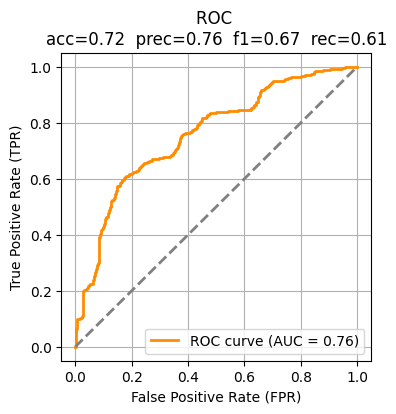

In [42]:
import matplotlib.pyplot as plt

def plot_roc_curve(metrics):
    """
    Función para graficar la curva ROC con FPR, TPR y el AUC en el título.

    Parámetros:
    - metrics: diccionario que contiene 'FPR', 'TPR' y 'AUC'.
    """
    title='ROC Curve'
    title_metrics = f'ROC \nacc={metrics['Accuracy']:.2f}  prec={metrics['Precision']:.2f}  f1={metrics['F1 Score']:.2f}  rec={metrics['Recall']:.2f}'

    plt.figure(figsize=(4, 4))
    plt.plot(metrics['FPR'], metrics['TPR'], color='darkorange', lw=2, label=f'ROC curve (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Línea diagonal de referencia
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title_metrics)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Llamada a la función
plot_roc_curve(metrics)


In [52]:
results_model['model'][0].get_booster().get_score()

{'Sex': 103.0, 'Educ': 393.0, 'MMSE': 244.0, 'GINI': 646.0, 'Diagnosis': 42.0}

# Antiguo

In [213]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif

# Crear datos inventados
np.random.seed(0)  # Fijar la semilla para reproducibilidad
n_samples = 100  # Número de muestras

# Crear características
X = pd.DataFrame({
    'feature_1': np.random.normal(0, 1, n_samples),
    'feature_2': np.random.normal(1, 2, n_samples),
    'feature_3': np.random.normal(-1, 1, n_samples),
    'feature_4': np.random.normal(2, 3, n_samples)
})

# Crear etiquetas de clase (0 o 1)
y = np.random.choice([0, 1], size=n_samples)

# Calcular F-score y p-valores para cada característica
f_scores, p_values = f_classif(X, y)

# Crear un DataFrame con los resultados
f_score_df = pd.DataFrame({'Feature': X.columns, 'F-score': f_scores, 'p-value': p_values})

# Mostrar los resultados
print(f_score_df)


     Feature   F-score   p-value
0  feature_1  1.755164  0.188310
1  feature_2  0.044922  0.832588
2  feature_3  1.354646  0.247293
3  feature_4  0.036762  0.848347
